### **BADM 576 Group Project: Home Credit Default Risk**

**Group 9:** _xiyingz2, cw30, eshwarv2, haixiao4, cyyeh2_

05-14-2023

##### **Data source and descriptions**

- _[Kaggle - Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/data)_

- _**application_train/test.csv**_
    - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    - Static data for all applications. One row represents one loan in our data sample.

- _**bureau.csv**_
    - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

- _**bureau_balance.csv**_
    - Monthly balances of previous credits in Credit Bureau.
    - This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

- _**POS_CASH_balance.csv**_
    - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

- _**credit_card_balance.csv**_
    - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

- _**previous_application.csv**_
    - All previous applications for Home Credit loans of clients who have loans in our sample.
    - There is one row for each previous application related to loans in our data sample.

- _**installments_payments.csv**_
    - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    - There is a) one row for every payment that was made plus b) one row each for missed payment.
    - One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

- _**HomeCredit_columns_description.csv**_
    - This file contains descriptions for the columns in the various data files.

.

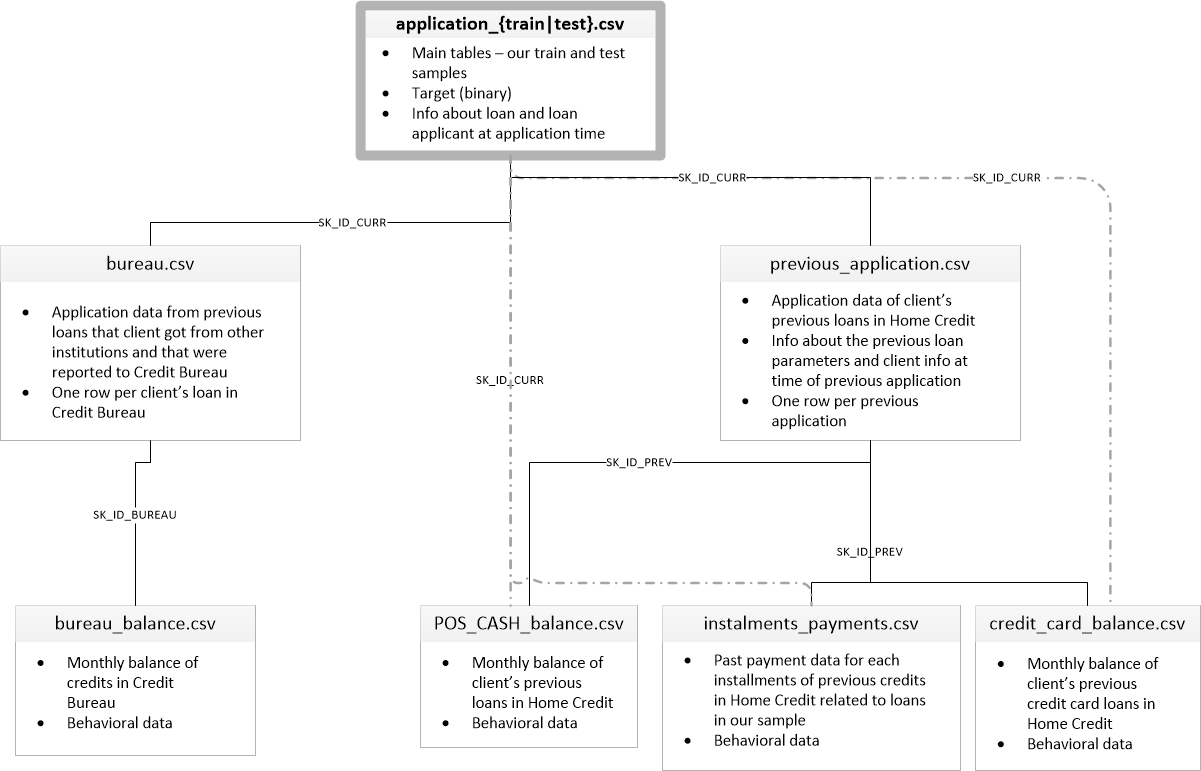

##### **Global varaiables**

In [ ]:
chunksize = 1e5
random_state = 123

##### **Dependencies**

In [ ]:
import pickle
import numpy as np
import pandas as pd
from random import randint, uniform
from scipy.stats import uniform
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, roc_auc_score, roc_auc_score, classification_report
from IPython.core.interactiveshell import InteractiveShell; InteractiveShell.ast_node_interactivity = 'all'

##### **Data import**

In [ ]:
# Specify path to directory

# path = '/My Drive/BADM 576/Project/data_orig/'                  # Selina
# path = '/My Drive/badm576_proj/data_orig/'                      # Crystal
# path = '/My Drive/BADM-576-Proj1/data_hcdr/'                    # Eshwar
# path = '/My Drive/BADM576_proj/data_orig/'                      # Freddy
path = '/My Drive/courses/s23/dsa/badm576_project/data_orig/'   # Harry

In [ ]:
# Mount to gDrive
root = '/content/drive/'
drive.mount(root, force_remount=True)

Mounted at /content/drive/


In [ ]:
# application_train
chunks = []
for chunk in pd.read_csv(filepath_or_buffer=root+path+'application_train.csv', chunksize=chunksize):
    chunks.append(chunk)
appl_train_orig = pd.concat(chunks)

# application_test
chunks = []
for chunk in pd.read_csv(filepath_or_buffer=root+path+'application_test.csv', chunksize=chunksize):
    chunks.append(chunk)
appl_test_orig = pd.concat(chunks)

In [ ]:
# bureau
chunks = []
for chunk in pd.read_csv(filepath_or_buffer=root+path+'bureau.csv', chunksize=chunksize):
    chunks.append(chunk)
bur_orig = pd.concat(chunks)

In [ ]:
# # bureau_balance
# chunks = []
# for chunk in pd.read_csv(filepath_or_buffer=root+path+'bureau_balance.csv', chunksize=chunksize):
#     chunks.append(chunk)
# bur_bal_orig = pd.concat(chunks)

In [ ]:
# previous_application
chunks = []
for chunk in pd.read_csv(filepath_or_buffer=root+path+'previous_application.csv', chunksize=chunksize):
    chunks.append(chunk)
prev_appl_orig = pd.concat(chunks)

In [ ]:
# # POS_CASH_balance
# chunks = []
# for chunk in pd.read_csv(filepath_or_buffer=root+path+'POS_CASH_balance.csv', chunksize=chunksize):
#     chunks.append(chunk)
# pos_orig = pd.concat(chunks)

In [ ]:
# installments_payments
chunks = []
for chunk in pd.read_csv(filepath_or_buffer=root+path+'installments_payments.csv', chunksize=chunksize):
    chunks.append(chunk)
install_orig = pd.concat(chunks)

In [ ]:
# credit_card_balance
chunks = []
for chunk in pd.read_csv(filepath_or_buffer=root+path+'credit_card_balance.csv', chunksize=chunksize):
    chunks.append(chunk)
credit_bal_orig = pd.concat(chunks)

##### **Exploratory data analysis**

###### _.head(), .info(), .isna()_

In [ ]:
# appl_train_orig
# appl_test_orig
# bur_orig
# bur_bal_orig
# prev_appl_orig
# pos_orig
# install_orig
# credit_bal_orig


data = appl_train_orig

data.head(4)
data.info(verbose=True, memory_usage=True, show_counts=False); print('')
na = data.isna().sum()[data.isna().sum()>0]
for index, value in na.items():
    print(f"{index}    {value}")

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

###### _Visualizations_

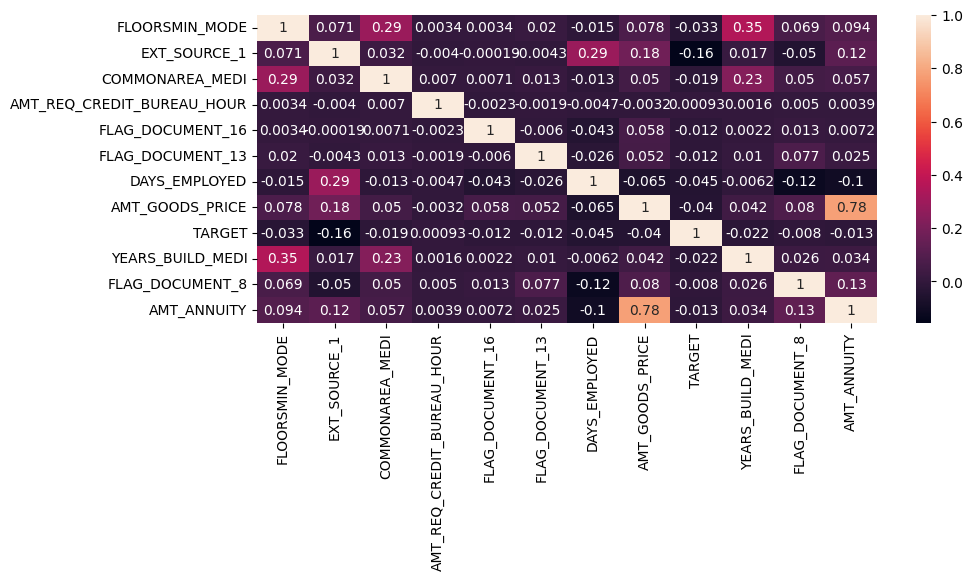

In [ ]:
# Select n numeric cols (excluding 'SK_ID_CURR')
n = 12
data_tmp = appl_train_orig\
            .drop(labels='SK_ID_CURR', axis=1)\
            .select_dtypes(include='number')\
            .sample(n=n, axis=1, random_state=random_state)

# Construct and display correlation matrix
corr_mtrx_tmp = data_tmp.corr()
fig, ax = plt.subplots(figsize=(10, 4));
sns.heatmap(corr_mtrx_tmp, annot=True);

array([[<Axes: title={'center': 'DAYS_LAST_PHONE_CHANGE'}>,
        <Axes: title={'center': 'YEARS_BUILD_AVG'}>],
       [<Axes: title={'center': 'REGION_POPULATION_RELATIVE'}>,
        <Axes: title={'center': 'LIVINGAPARTMENTS_MEDI'}>],
       [<Axes: title={'center': 'FLOORSMIN_MEDI'}>,
        <Axes: title={'center': 'DAYS_ID_PUBLISH'}>]], dtype=object)

<ipython-input-14-6b2a90c96540>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tmp[str_label] = appl_train_orig[str_label]


Text(0, 0.5, 'TARGET')

Text(0.5, 1.0, 'DAYS_LAST_PHONE_CHANGE')

Text(0, 0.5, 'TARGET')

Text(0.5, 1.0, 'YEARS_BUILD_AVG')

Text(0, 0.5, 'TARGET')

Text(0.5, 1.0, 'REGION_POPULATION_RELATIVE')

Text(0, 0.5, 'TARGET')

Text(0.5, 1.0, 'LIVINGAPARTMENTS_MEDI')

Text(0, 0.5, 'TARGET')

Text(0.5, 1.0, 'FLOORSMIN_MEDI')

Text(0, 0.5, 'TARGET')

Text(0.5, 1.0, 'DAYS_ID_PUBLISH')

<Figure size 640x480 with 0 Axes>

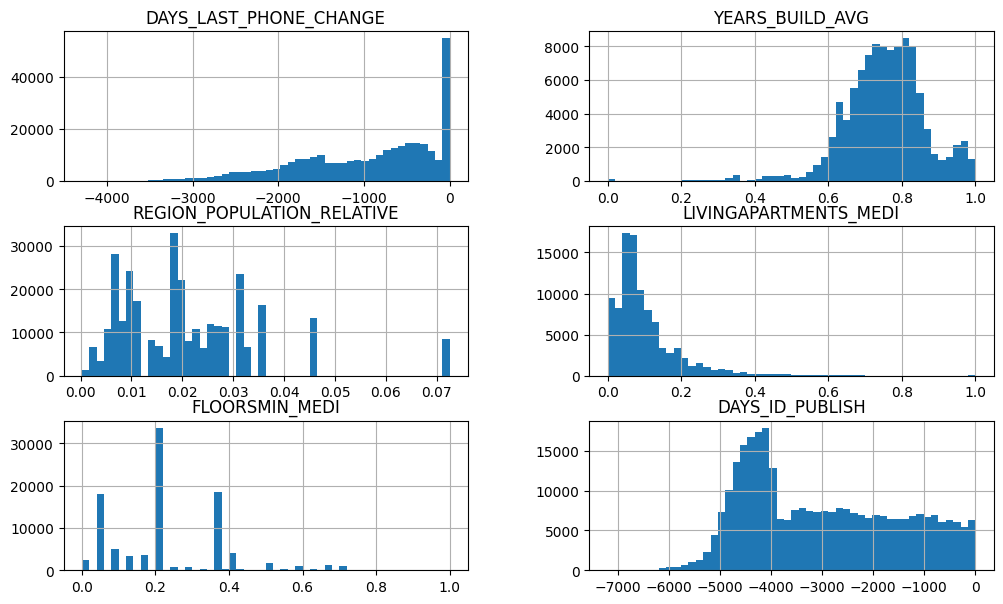

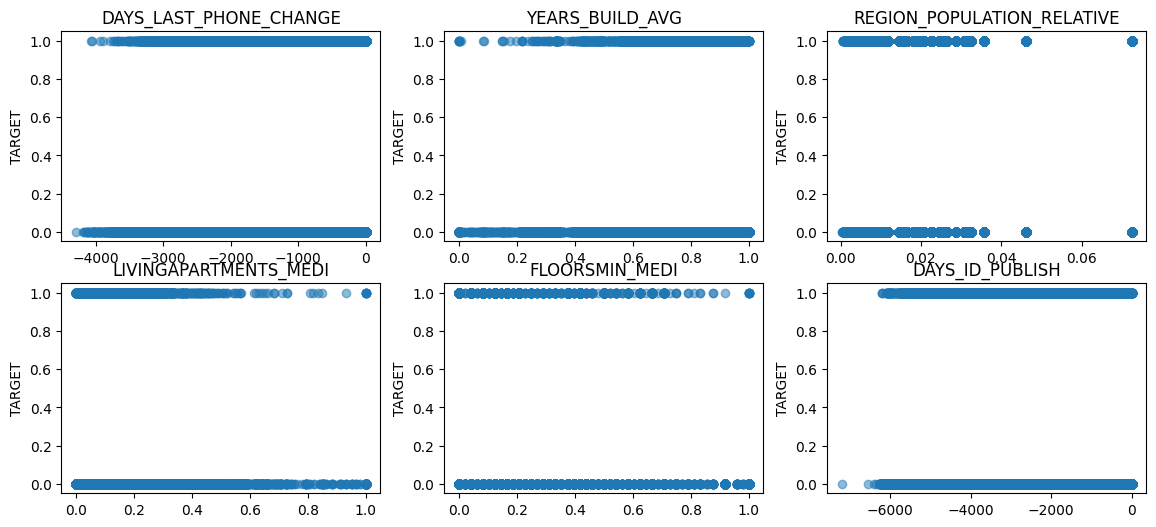

In [ ]:
# Minimum requirement 04:
# Generate histograms for any six numerical features in application_train.csv

str_label = 'TARGET'
alpha = 0.5
bins = 50

# Viz histogram
data_tmp = appl_train_orig[['DAYS_LAST_PHONE_CHANGE',
                          'YEARS_BUILD_AVG',
                          'REGION_POPULATION_RELATIVE',
                          'LIVINGAPARTMENTS_MEDI',
                          'FLOORSMIN_MEDI',
                          'DAYS_ID_PUBLISH']];
plt.tight_layout();
data_tmp.hist(figsize=(12, 7), bins=bins); print('');

# Viz relationships with target variable (scatter plots)
data_tmp[str_label] = appl_train_orig[str_label]
list_iter_tmp = iter(data_tmp.columns)
_, axs = plt.subplots(2, 3, figsize=(14, 6)); axs = axs.flatten();
for ax in axs:
    str_feat_curr = next(list_iter_tmp);
    ax.scatter(data_tmp[str_feat_curr], data_tmp[str_label], alpha=alpha);
    ax.set_ylabel(str_label);
    ax.set_title(str_feat_curr);

##### _**(1, 2) Problem statement and candidate models**_

This is a classification problem predicting how capable each applicant is at repaying a loan

- _**`Random forest`**_
    - Advantage: shorter traning time and higher interpretability
    - Disadvantage: lesser performance on complex data

- _**`Random forest`**_
    - Advantage: ability to handle large datasets, missing values, and outliers
    - Disadvantage: overfitting may be a concern

- _**`XGBoost`**_
    - Advantage: good bastline performance and robustness
    - Disadvantage: training and tunning may be more time consuming

##### **(3) Feature engineering**

In [ ]:
# Create 5 new features as well as master data


str_new_feat_tmp = 'cf_cnt_prev_appl_cnt'
df_cf_prev_appl_cnt = prev_appl_orig[['SK_ID_PREV', 'SK_ID_CURR']].groupby('SK_ID_CURR').count().reset_index()
df_cf_prev_appl_cnt.rename(columns={df_cf_prev_appl_cnt.columns[-1]: str_new_feat_tmp}, inplace=True)
df_cf_prev_appl_cnt.sort_values(str_new_feat_tmp, ascending=False, inplace=True)
df_join_1_train = pd.merge(appl_train_orig,
                           df_cf_prev_appl_cnt,
                           on='SK_ID_CURR',
                           how='left')
df_join_1_test = pd.merge(appl_test_orig,
                          df_cf_prev_appl_cnt,
                          on='SK_ID_CURR',
                          how='left')

str_new_feat_tmp = 'cf_prev_loan_cnt'
df_cf_prev_loan_cnt = bur_orig.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count()\
                                        .rename(columns={'SK_ID_BUREAU': str_new_feat_tmp})
df_join_2_train = pd.merge(df_join_1_train,
                           df_cf_prev_loan_cnt,
                           on='SK_ID_CURR',
                           how='left')
df_join_2_test = pd.merge(df_join_1_test,
                          df_cf_prev_loan_cnt,
                          on='SK_ID_CURR',
                          how='left')

str_new_feat_tmp = 'cf_draw_pct'
df_cf_draw_pct = credit_bal_orig[['SK_ID_CURR']]
df_cf_draw_pct[str_new_feat_tmp] = credit_bal_orig['AMT_DRAWINGS_CURRENT']/credit_bal_orig['AMT_CREDIT_LIMIT_ACTUAL']
df_cf_draw_pct = df_cf_draw_pct.groupby('SK_ID_CURR', as_index=False)[str_new_feat_tmp].sum()
df_join_3_train = pd.merge(df_join_2_train,
                           df_cf_draw_pct,
                           on='SK_ID_CURR',
                           how='left')
df_join_3_test = pd.merge(df_join_2_test,
                          df_cf_draw_pct,
                          on='SK_ID_CURR',
                          how='left')

str_new_feat_tmp = 'cf_reci_pct'
df_cf_reci_pct = credit_bal_orig[['SK_ID_CURR']]
df_cf_reci_pct[str_new_feat_tmp] = credit_bal_orig['AMT_RECIVABLE']/credit_bal_orig['AMT_BALANCE']
df_cf_reci_pct = df_cf_reci_pct.groupby('SK_ID_CURR', as_index=False)[str_new_feat_tmp].sum()
df_join_4_train = pd.merge(df_join_3_train,
                           df_cf_reci_pct,
                           on='SK_ID_CURR',
                           how='left')
df_join_4_test = pd.merge(df_join_3_test,
                           df_cf_reci_pct,
                           on='SK_ID_CURR',
                           how='left')

str_new_feat_tmp = 'cf_late_pay_days'
df_cf_late_pay_days = install_orig[['SK_ID_CURR']]
df_cf_late_pay_days[str_new_feat_tmp] = install_orig['DAYS_ENTRY_PAYMENT']-install_orig['DAYS_INSTALMENT']
df_cf_late_pay_days = df_cf_late_pay_days.groupby('SK_ID_CURR', as_index=False)[str_new_feat_tmp].sum()
df_join_5_train = pd.merge(df_join_4_train,
                           df_cf_late_pay_days,
                           on='SK_ID_CURR',
                           how='left')
df_join_5_test = pd.merge(df_join_4_test,
                           df_cf_late_pay_days,
                           on='SK_ID_CURR',
                           how='left')

str_new_feat_tmp = 'cf_instl_pay_pct'
df_cf_instl_pay_pct = install_orig[['SK_ID_CURR']]
df_cf_instl_pay_pct[str_new_feat_tmp] = install_orig['AMT_PAYMENT']/install_orig['AMT_INSTALMENT']
df_cf_instl_pay_pct = df_cf_instl_pay_pct.groupby('SK_ID_CURR', as_index=False)[str_new_feat_tmp].sum()
df_join_6_train = pd.merge(df_join_5_train,
                           df_cf_instl_pay_pct,
                           on='SK_ID_CURR',
                           how='left')
df_join_6_test = pd.merge(df_join_5_test,
                          df_cf_instl_pay_pct,
                          on='SK_ID_CURR',
                          how='left')

<ipython-input-15-f0588612371f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cf_draw_pct[str_new_feat_tmp] = credit_bal_orig['AMT_DRAWINGS_CURRENT']/credit_bal_orig['AMT_CREDIT_LIMIT_ACTUAL']
<ipython-input-15-f0588612371f>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cf_reci_pct[str_new_feat_tmp] = credit_bal_orig['AMT_RECIVABLE']/credit_bal_orig['AMT_BALANCE']
<ipython-input-15-f0588612371f>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [ ]:
# Drop features with more than 5% missing values
thresh = len(df_join_6_train) * .95
df_join_6_train = df_join_6_train.dropna(thresh=thresh, axis=1)
thresh = len(df_join_6_test) * .95
df_join_6_test = df_join_6_test.dropna(thresh=thresh, axis=1)

In [ ]:
# data = df_join_6_train
# data.head(4)
# data.info(verbose=True, memory_usage=True, show_counts=False); print('')
# na = data.isna().sum()[data.isna().sum()>0]
# for index, value in na.items():
#     print(f"{index}    {value}")

In [ ]:
# data = df_join_6_test
# data.head(4)
# data.info(verbose=True, memory_usage=True, show_counts=False); print('')
# na = data.isna().sum()[data.isna().sum()>0]
# for index, value in na.items():
#     print(f"{index}    {value}")

In [ ]:
# for col in df_join_6_train.columns:
#     unique_vals = df_join_6_train[col].nunique()
#     print(f"Unique values in column {col}: {unique_vals}")

In [ ]:
# df_join_6_train['OBS_30_CNT_SOCIAL_CIRCLE'].value_counts()

feat_cont_ =['CNT_CHILDREN',
            'AMT_INCOME_TOTAL',
            'AMT_CREDIT',
            'AMT_ANNUITY',
            'AMT_GOODS_PRICE',
            'REGION_POPULATION_RELATIVE',
            'DAYS_BIRTH',
            'DAYS_EMPLOYED',
            'DAYS_REGISTRATION',
            'DAYS_ID_PUBLISH',
            'CNT_FAM_MEMBERS',
            'HOUR_APPR_PROCESS_START',
            'EXT_SOURCE_2',
            'OBS_30_CNT_SOCIAL_CIRCLE',
            'DEF_30_CNT_SOCIAL_CIRCLE',
            'OBS_60_CNT_SOCIAL_CIRCLE',
            'DEF_60_CNT_SOCIAL_CIRCLE',
            'DAYS_LAST_PHONE_CHANGE',
            'REGION_POPULATION_RELATIVE',
            'cf_cnt_prev_appl_cnt',
            'cf_prev_loan_cnt',
            'cf_draw_pct',
            'cf_late_pay_days',
            'cf_instl_pay_pct']

feat_cat_ = ['NAME_CONTRACT_TYPE',
            'CODE_GENDER',
            'FLAG_OWN_CAR',
            'FLAG_OWN_REALTY',
            'NAME_TYPE_SUITE',
            'NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS',
            'NAME_HOUSING_TYPE',
            'FLAG_MOBIL',
            'FLAG_EMP_PHONE',
            'FLAG_WORK_PHONE',
            'FLAG_CONT_MOBILE',
            'FLAG_PHONE',
            'FLAG_EMAIL',
            'REGION_RATING_CLIENT',
            'REGION_RATING_CLIENT_W_CITY',
            'WEEKDAY_APPR_PROCESS_START',
            'REG_REGION_NOT_LIVE_REGION',
            'REG_REGION_NOT_WORK_REGION',
            'LIVE_REGION_NOT_WORK_REGION',
            'REG_CITY_NOT_LIVE_CITY',
            'REG_CITY_NOT_WORK_CITY',
            'LIVE_CITY_NOT_WORK_CITY',
            'ORGANIZATION_TYPE',
            'TARGET']

feat_cat = ['NAME_CONTRACT_TYPE',
            'CODE_GENDER',
            'FLAG_OWN_CAR',
            'FLAG_OWN_REALTY',
            'NAME_TYPE_SUITE',
            'NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS',
            'NAME_HOUSING_TYPE',
            'FLAG_MOBIL',
            'FLAG_EMP_PHONE',
            'FLAG_WORK_PHONE',
            'FLAG_CONT_MOBILE',
            'FLAG_PHONE',
            'FLAG_EMAIL',
            'REGION_RATING_CLIENT',
            'REGION_RATING_CLIENT_W_CITY',
            'WEEKDAY_APPR_PROCESS_START',
            'REG_REGION_NOT_LIVE_REGION',
            'REG_REGION_NOT_WORK_REGION',
            'LIVE_REGION_NOT_WORK_REGION',
            'REG_CITY_NOT_LIVE_CITY',
            'REG_CITY_NOT_WORK_CITY',
            'LIVE_CITY_NOT_WORK_CITY',
            'ORGANIZATION_TYPE',]

feat_cont =['CNT_CHILDREN',
            'AMT_INCOME_TOTAL',
            'AMT_CREDIT',
            'AMT_ANNUITY',
            'AMT_GOODS_PRICE',
            'REGION_POPULATION_RELATIVE',
            'DAYS_BIRTH',
            'DAYS_EMPLOYED',
            'DAYS_REGISTRATION',
            'DAYS_ID_PUBLISH',
            'CNT_FAM_MEMBERS',
            'HOUR_APPR_PROCESS_START',
            'EXT_SOURCE_2',
            'OBS_30_CNT_SOCIAL_CIRCLE',
            'DEF_30_CNT_SOCIAL_CIRCLE',
            'OBS_60_CNT_SOCIAL_CIRCLE',
            'DEF_60_CNT_SOCIAL_CIRCLE',
            'DAYS_LAST_PHONE_CHANGE',
            'REGION_POPULATION_RELATIVE',]

In [ ]:
df_join_6_train = df_join_6_train.loc[:, df_join_6_train.columns.isin(feat_cont_) | df_join_6_train.columns.isin(feat_cat_)]
df_join_6_test = df_join_6_test.loc[:, df_join_6_test.columns.isin(feat_cont_) | df_join_6_test.columns.isin(feat_cat)]
# df_join_6_test = (df_join_6_test[df_join_6_test.columns.difference(df_join_6_train.columns)]).copy()
mask = list(df_join_6_train.columns.delete(0))
df_join_6_test = df_join_6_test[mask]

In [ ]:
df_join_6_train.shape
df_join_6_test.shape

(307511, 44)

(48744, 43)

##### **(4, 5) Preprocessing and pipelines**

Preprocessing steps
- Drop features with too much missing values
- Identify continous and categorical features
- Fill NAs using pipeline (median for continous features, and majority class for categorical features)
- Encode categorical features

In [ ]:
# Isolate training and testing sets
X_train = (df_join_6_train.drop('TARGET', axis=1)).copy()
y_train = (df_join_6_train[['TARGET']]).copy()
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train,
                                                    # test_size=.005,
                                                    test_size=.01,
                                                    random_state=random_state,
                                                    stratify=y_train)
X_train, _, y_train, _ = train_test_split(X_train,
                                          y_train,
                                        #   test_size=.98,
                                          test_size=.96,
                                          random_state=random_state,
                                          stratify=y_train)

In [ ]:
# y_train.value_counts()[0]/y_train.value_counts()[1]
# y_test.value_counts()[0]/y_test.value_counts()[1]
df_join_6_test.shape
X_train.shape
X_test.shape

(48744, 43)

(12177, 43)

(3076, 43)

In [ ]:
# define the preprocessing steps for numerical and categorical columns
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[  ('imputer', SimpleImputer(strategy='most_frequent')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
# define the column transformer that applies the preprocessing steps to specific columns
preprocessor = ColumnTransformer(transformers=[ ('num', numerical_transformer, feat_cont),
                                                ('cat', categorical_transformer, feat_cat)])

In [ ]:
# define the pipelines for each model
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42))])
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))])
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier(random_state=42))])
# nn_pipeline = Pipeline(steps=[  ('preprocessor', preprocessor),
#                                 ('classifier', Sequential([Dense(32, activation='relu', input_dim=X_train.shape[1]),
#                                                            Dense(1, activation='sigmoid')]))])

##### **(6, 7, 8) modeling and error analysis**

Metrics for error analysis


- _**`Precision`**_ $ = {TP \over TP+FP} $

- _**`Sensitivity`**_ $ = {TP \over TP+FN} $

- _**`F1 Score`**_ $ = {2 (Precision * Sensitivity) \over Precision + Sensitivity} $

- _**`Area under the ROC Curve (AUC)`**_

We will be suing sensitivity, F1 score, and AUC as metrics for error analysis

In [ ]:
X_train.shape
y_train.shape

(12177, 43)

(12177, 1)

###### Decision tree

In [ ]:
# Define scoring metrics
scoring = {'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score),
           'auc': make_scorer(roc_auc_score)}

# # define the hyperparameter distribution to search
param_dist = {'classifier__max_depth': list(range(3, 21)),
              'classifier__min_samples_split': list(range(2, 21)),
              'classifier__min_samples_leaf': list(range(2, 21))}

# define the RandomizedSearchCV object
dt_grid = RandomizedSearchCV(estimator=dt_pipeline,
                             param_distributions=param_dist,
                             n_iter=30,
                             scoring=scoring,
                             refit='auc',
                             cv=4,
                             n_jobs=-1,
                             random_state=random_state)

# Fit the grid search to the data
dt_grid.fit(X_train, y_train)

# Print validation performance and best hyperparameters
print("Validation performance:")
for metric in scoring.keys():
    print(f"{metric}: {dt_grid.cv_results_['mean_test_' + metric][dt_grid.best_index_]}")
print("\nBest hyperparameters found:")
print(dt_grid.best_params_)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['CNT_CHILDREN',
                                                                                'AMT_INCOME_TOTAL',
                                                                                'AMT_CREDIT',
                                                                                'AMT_ANNUITY',
                                                                                'AMT_GOODS_PRICE',
                                                                                'REGION_POPULATION_RELATIVE',
                                                                                'DAYS_BIRTH',
                                                                                'DAYS_EMPLOYED',
                                                                                'DAYS_REGISTRATI...
                   param_distributions={'classifier__max_depth': [3, 4, 5, 6, 7,
                                                                  8, 9, 10, 11,
                                                                  12, 13, 14,
                                                                  15, 16, 17,
                                                                  18, 19, 20],
                                        'classifier__min_samples_leaf': [2, 3,
                                                                         4, 5,
                                                                         6, 7,
                                                                         8, 9,
                                                                         10, 11,
                                                                         12, 13,
                                                                         14, 15,
                                                                         16, 17,
                                                                         18, 19,
                                                                         20],
                                        'classifier__min_samples_split': [2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20]},
                   random_state=123, refit='auc',
                   scoring={'auc': make_scorer(roc_auc_s

Validation performance:
recall: 0.08139206902273104
f1_score: 0.11223098738749708
auc: 0.5246159911179449

Best hyperparameters found:
{'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 8, 'classifier__max_depth': 20}


In [ ]:
# Refit the model with the best hyperparameters on the entire training dataset
best_dt_pipeline = dt_grid.best_estimator_
best_dt_pipeline.fit(X_train, y_train)

# Make predictions on testing set and evaluate model performance
test_pred_rf = best_dt_pipeline.predict(X_test)

# Calculate classification metrics
print(classification_report(y_test, test_pred_rf))

# Calculate AUC score
test_prob_xgb = best_dt_pipeline.predict_proba(X_test)[:, 1]
test_auc_xgb = roc_auc_score(y_test, test_prob_xgb)
print(f"AUC score on the test data is {test_auc_xgb}")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEM...
                                                   'REGION_RATING_CLIENT_W_CITY',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'REG_REGION_NOT_LIVE_REGION',
                                                   'REG_REGION_NOT_WORK_REGION',
                                                   'LIVE_REGION_NOT_WORK_REGION',
                                                   'REG_CITY_NOT_LIVE_CITY',
                                                   'REG_CITY_NOT_WORK_CITY',
                                                   'LIVE_CITY_NOT_WORK_CITY',
                                                   'ORGANIZATION_TYPE'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=20, min_samples_leaf=8,
                                        min_samples_split=8,
                                        random_state=42))])

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2828
           1       0.13      0.06      0.08       248

    accuracy                           0.89      3076
   macro avg       0.53      0.51      0.51      3076
weighted avg       0.86      0.89      0.87      3076

AUC score on the test data is 0.5533589793311128


###### Random forest

In [ ]:
# Define scoring metrics
scoring = {'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score),
           'auc': make_scorer(roc_auc_score)}

# # define the hyperparameter distribution to search
param_dist = {'classifier__max_depth': list(range(3, 21)),
              'classifier__min_samples_split': list(range(2, 21)),
              'classifier__min_samples_leaf': list(range(2, 21)),
              'classifier__n_estimators': list(range(10, 100)),}

# define the RandomizedSearchCV object
rf_grid = RandomizedSearchCV(estimator=rf_pipeline,
                             param_distributions=param_dist,
                             n_iter=30,
                             scoring=scoring,
                             refit='auc',
                             cv=4,
                             n_jobs=-1,
                             random_state=random_state)

# Fit the grid search to the data
rf_grid.fit(X_train, y_train)

# Print validation performance and best hyperparameters
print("Validation performance:")
for metric in scoring.keys():
    print(f"{metric}: {rf_grid.cv_results_['mean_test_' + metric][rf_grid.best_index_]}")
print("\nBest hyperparameters found:")
print(rf_grid.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['CNT_CHILDREN',
                                                                                'AMT_INCOME_TOTAL',
                                                                                'AMT_CREDIT',
                                                                                'AMT_ANNUITY',
                                                                                'AMT_GOODS_PRICE',
                                                                                'REGION_POPULATION_RELATIVE',
                                                                                'DAYS_BIRTH',
                                                                                'DAYS_EMPLOYED',
                                                                                'DAYS_REGISTRATI...
                                                                         20],
                                        'classifier__min_samples_split': [2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20],
                                        'classifier__n_estimators': [10, 11, 12,
                                                                     13, 14, 15,
                                                                     16, 17, 18,
                                                                     19, 20, 21,
                                                                     22, 23, 24,
                                                                     25, 26, 27,
                                                                     28, 29, 30,
                                                                     31, 32, 33,
                                                                     34, 35, 36,
                                                                     37, 38, 39, ...]},
                   random_state=123, refit='auc',
                   scoring={'auc': make_scorer(roc_auc_score),
                            'f1_score': make_scorer(f1_score),
                            'recall': make_scorer(recall_score)})

Validation performance:
recall: 0.0
f1_score: 0.0
auc: 0.5

Best hyperparameters found:
{'classifier__n_estimators': 49, 'classifier__min_samples_split': 11, 'classifier__min_samples_leaf': 12, 'classifier__max_depth': 11}


In [ ]:
# Refit the model with the best hyperparameters on the entire training dataset
best_rf_pipeline = rf_grid.best_estimator_
best_rf_pipeline.fit(X_train, y_train)

# Make predictions on testing set and evaluate model performance
test_pred_rf = best_rf_pipeline.predict(X_test)

# Calculate classification metrics
print(classification_report(y_test, test_pred_rf))

# Calculate AUC score
test_prob_xgb = best_rf_pipeline.predict_proba(X_test)[:, 1]
test_auc_xgb = roc_auc_score(y_test, test_prob_xgb)
print(f"AUC score on the test data is {test_auc_xgb}")

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEM...
                                                   'REGION_RATING_CLIENT_W_CITY',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'REG_REGION_NOT_LIVE_REGION',
                                                   'REG_REGION_NOT_WORK_REGION',
                                                   'LIVE_REGION_NOT_WORK_REGION',
                                                   'REG_CITY_NOT_LIVE_CITY',
                                                   'REG_CITY_NOT_WORK_CITY',
                                                   'LIVE_CITY_NOT_WORK_CITY',
                                                   'ORGANIZATION_TYPE'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=11, min_samples_leaf=12,
                                        min_samples_split=11, n_estimators=49,
                                        random_state=42))])

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2828
           1       0.00      0.00      0.00       248

    accuracy                           0.92      3076
   macro avg       0.46      0.50      0.48      3076
weighted avg       0.85      0.92      0.88      3076

AUC score on the test data is 0.666717046128576


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### XGBoost

In [ ]:
# Define scoring metrics
scoring = {'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score),
           'auc': make_scorer(roc_auc_score)}

# # define the hyperparameter distribution to search
param_dist = {
    # 'classifier__learning_rate': np.random.uniform(low=.001, high=.5, size=100),
              'classifier__max_depth': list(range(3, 21)),
              'classifier__subsample': np.random.uniform(low=.1, high=.9, size=100),
              'classifier__colsample_bytree': np.random.uniform(low=.1, high=.9, size=100),
              'classifier__n_estimators': list(range(10, 100)),}

# define the RandomizedSearchCV object
xgb_grid = RandomizedSearchCV(estimator=xgb_pipeline,
                              param_distributions=param_dist,
                              n_iter=30,
                              scoring=scoring,
                              refit='auc',
                              cv=4,
                              n_jobs=-1,
                              random_state=random_state)

# Fit the grid search to the data
xgb_grid.fit(X_train, y_train)

# Print validation performance and best hyperparameters
print("Validation performance:")
for metric in scoring.keys():
    print(f"{metric}: {xgb_grid.cv_results_['mean_test_' + metric][xgb_grid.best_index_]}")
print("\nBest hyperparameters found:")
print(xgb_grid.best_params_)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['CNT_CHILDREN',
                                                                                'AMT_INCOME_TOTAL',
                                                                                'AMT_CREDIT',
                                                                                'AMT_ANNUITY',
                                                                                'AMT_GOODS_PRICE',
                                                                                'REGION_POPULATION_RELATIVE',
                                                                                'DAYS_BIRTH',
                                                                                'DAYS_EMPLOYED',
                                                                                'DAYS_REGISTRATI...
       0.13188127, 0.86994915, 0.26745795, 0.13642573, 0.66409238,
       0.32160317, 0.87225862, 0.77761951, 0.71649299, 0.87948295,
       0.40205924, 0.87461226, 0.49639929, 0.74694086, 0.36834761,
       0.80480723, 0.43162303, 0.79360645, 0.12510312, 0.33932278])},
                   random_state=123, refit='auc',
                   scoring={'auc': make_scorer(roc_auc_score),
                            'f1_score': make_scorer(f1_score),
                            'recall': make_scorer(recall_score)})

Validation performance:
recall: 0.08848929815828771
f1_score: 0.12089934660284864
auc: 0.5276730555533237

Best hyperparameters found:
{'classifier__subsample': 0.13642573129952107, 'classifier__n_estimators': 70, 'classifier__max_depth': 14, 'classifier__colsample_bytree': 0.14931978686609898}


In [ ]:
# Refit the model with the best hyperparameters on the entire training dataset
best_xgb_pipeline = xgb_grid.best_estimator_
best_xgb_pipeline.fit(X_train, y_train)

# Make predictions on testing set and evaluate model performance
test_pred_rf = best_xgb_pipeline.predict(X_test)

# Calculate classification metrics
print(classification_report(y_test, test_pred_rf))

# Calculate AUC score
test_prob_xgb = best_xgb_pipeline.predict_proba(X_test)[:, 1]
test_auc_xgb = roc_auc_score(y_test, test_prob_xgb)
print(f"AUC score on the test data is {test_auc_xgb}")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEM...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=14, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=70,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2828
           1       0.10      0.05      0.07       248

    accuracy                           0.89      3076
   macro avg       0.51      0.51      0.50      3076
weighted avg       0.85      0.89      0.87      3076

AUC score on the test data is 0.5728144819090203


##### **(9, 10) Model selection and predictions**

In [ ]:
# Save best model
with open('best_random_forest', 'wb') as file:
    pickle.dump(best_rf_pipeline, file)

In [ ]:
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
predictions = best_xgb_pipeline.predict(df_join_6_test)
pd.DataFrame(predictions).to_csv('predictions.csv', index=False)